## Importing Libraries
**Importing the libraries needed to build this program**

In [6]:
ls

 Volume in drive C is Windows
 Volume Serial Number is E2EC-E904

 Directory of c:\Users\T\Desktop\Al_Project\Traffic-Sign-Detection-Using-CNN

07/05/2025  02:37 CH    <DIR>          .
03/05/2025  03:27 CH    <DIR>          ..
03/05/2025  03:24 CH                12 .gitignore
03/05/2025  10:27 SA    <DIR>          Data
03/05/2025  08:32 SA             1.096 LICENSE
03/05/2025  10:49 CH             4.645 main.py
03/05/2025  03:09 CH         1.428.200 model.h5
03/05/2025  09:09 SA        18.785.573 model.keras
03/05/2025  03:33 CH               176 README.md
03/05/2025  08:58 SA                98 requirements.txt
18/05/2025  10:57 SA           113.326 Training.ipynb
03/05/2025  08:41 SA    <DIR>          venv
               8 File(s)     20.333.126 bytes
               4 Dir(s)  11.308.306.432 bytes free


In [ ]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hàm tải và xử lý ảnh
def load_images_from_directory(path, image_size=(30, 30)):
    images = os.listdir(path)
    data = []
    labels = []
    class_id = int(os.path.basename(path))  # Lấy ID lớp từ tên thư mục

    for image_filename in images:
        try:
            image = Image.open(os.path.join(path, image_filename))
            image = image.resize(image_size) # thay đổi kích thước ảnh về kích thước 30x30 pixel
            image = np.array(image) # Chuyển ảnh thành 1 mảng numpy (30,30,3) 3 :số kênh màu. Mỗi pixel có 3 giá trị R,G,B nằm trong khoảng 0 đến 255
            image = image / 255.0  # Mỗi pixel của ảnh RGB có giá trị từ 0 đến 255, chia cho 255 để đưa các giá trị về khoảng [0,1]
            data.append(image)
            labels.append(class_id)
        except:
            print(f"Lỗi khi tải ảnh: {os.path.join(path, image_filename)}")

    return data, labels

# Tải toàn bộ ảnh và nhãn
data = [] # danh sách chứa các ảnh xử lý
labels = [] # danh sách chứa nhãn tương ứng của mỗi ảnh
num_classes = 43 # 43 lớp 
current_path = os.getcwd()

for class_id in range(num_classes):
    path = os.path.join(current_path, 'data/Train', str(class_id))
    class_data, class_labels = load_images_from_directory(path)
    data.extend(class_data)
    labels.extend(class_labels)

data = np.array(data)
labels = np.array(labels)

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# One-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Tạo ImageDataGenerator với tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test_one_hot)

# Xây dựng mô hình CNN với BatchNormalization
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# ✅ Hiển thị kiến trúc mô hình
model.summary()

# Biên dịch mô hình
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Huấn luyện
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=test_generator,
    validation_steps=len(X_test) // 32,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Hàm vẽ biểu đồ Accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Biểu đồ Độ chính xác')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Hàm vẽ biểu đồ Loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Biểu đồ Mất mát (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ biểu đồ kết quả huấn luyện
plot_accuracy(history)
plot_loss(history)

# Dự đoán và hiển thị ma trận nhầm lẫn
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)
plt.title("Ma trận nhầm lẫn")
plt.show()


c:\Users\T\Desktop\Al_Project\Traffic-Sign-Detection-Using-CNN\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,795 (1.17 MB)

 Trainable params: 305,515 (1.17 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/15


c:\Users\T\Desktop\Al_Project\Traffic-Sign-Detection-Using-CNN\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


980/980 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.1684 - loss: 3.4303 - val_accuracy: 0.6403 - val_loss: 1.2496 - learning_rate: 0.0010
Epoch 2/15
  1/980 ━━━━━━━━━━━━━━━━━━━━ 1:16 78ms/step - accuracy: 0.7500 - loss: 0.9166

c:\Users\T\Desktop\Al_Project\Traffic-Sign-Detection-Using-CNN\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7500 - loss: 0.9166 - val_accuracy: 0.6347 - val_loss: 1.2641 - learning_rate: 0.0010
Epoch 3/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 76s 78ms/step - accuracy: 0.7397 - loss: 0.8258 - val_accuracy: 0.9792 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 4/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9062 - loss: 0.2583 - val_accuracy: 0.9782 - val_loss: 0.0870 - learning_rate: 0.0010
Epoch 5/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 76s 77ms/step - accuracy: 0.9385 - loss: 0.2094 - val_accuracy: 0.9858 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 6/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9062 - loss: 0.2182 - val_accuracy: 0.9861 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 7/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 80s 81ms/step - accuracy: 0.9628 - loss: 0.1270 - val_accuracy: 0.9898 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 8/15
  1/980 ━━━━━━━━━━━━━━━━━━━━ 1:18 80ms/step - accuracy: 1.0000 - loss: 0.0924

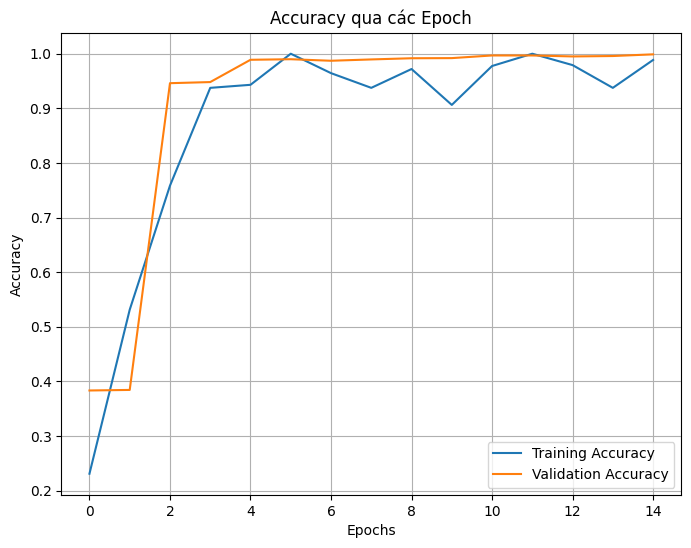

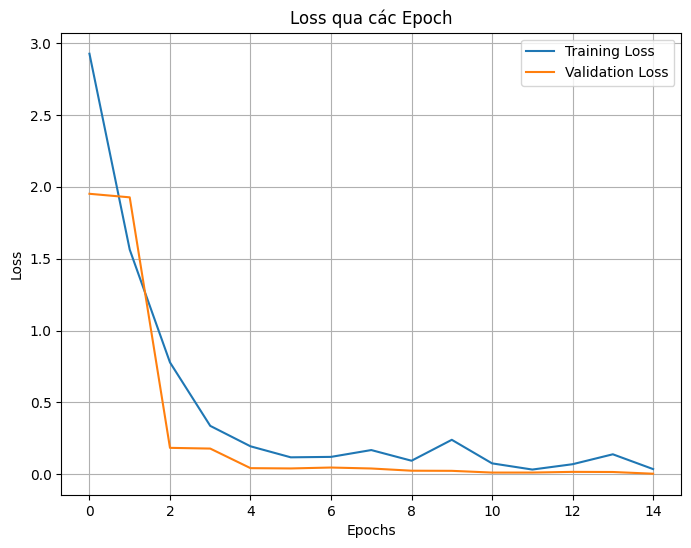

Accuracy cuối cùng trên tập huấn luyện: 98.86%
Accuracy cuối cùng trên tập kiểm tra: 99.89%
Loss cuối cùng trên tập huấn luyện: 0.0357
Loss cuối cùng trên tập kiểm tra: 0.0035


In [8]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy qua các Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss qua các Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# In ra accuracy và loss cuối cùng của tập train và test
def print_final_metrics(history):
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"Accuracy cuối cùng trên tập huấn luyện: {final_train_acc*100:.2f}%")
    print(f"Accuracy cuối cùng trên tập kiểm tra: {final_val_acc*100:.2f}%")
    print(f"Loss cuối cùng trên tập huấn luyện: {final_train_loss:.4f}")
    print(f"Loss cuối cùng trên tập kiểm tra: {final_val_loss:.4f}")

# Gọi hàm để vẽ và in ra số liệu
plot_accuracy(history)
plot_loss(history)
print_final_metrics(history)


In [9]:
#testing accuracy on test dataset
from sklearn.metrics import accuracy_score
import pandas as pd

y_test = pd.read_csv('data/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]

for img in imgs:
    image = Image.open("data/"+img)
    image = image.resize((30,30))
    data.append(np.array(image))

X_test=np.array(data)

# Make predictions on the test data
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

model.save('model.h5')


395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


0.7110055423594616
